# Fake Job Postings Detection Using Machine Learning

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

In [41]:
nltk.download('stopwords') # Download NLTK stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shoai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load Dataset

In [5]:
df = pd.read_csv('fake_job_postings.csv') 
print(df['fraudulent'].value_counts()) 

fraudulent
0    17014
1      866
Name: count, dtype: int64


In [7]:
print(df.head())

   job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving quality of life thro...   
4        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Foo

In [9]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [11]:
df.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


## Data Analysis

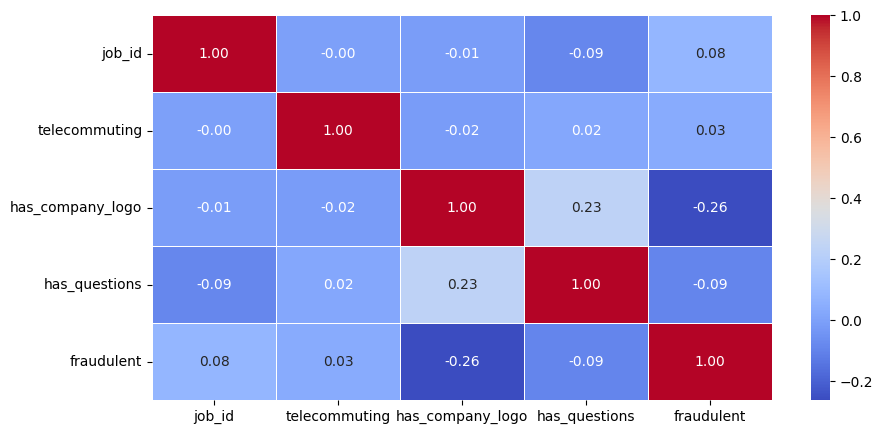

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
numerical_data = df.select_dtypes(include=['int64', 'float64'])
corr_matrix = numerical_data.corr()
plt.figure(figsize=(10,5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True , linewidths = 0.5)
plt.show()

## Combine Relevant Text Fields and Clean Text

In [19]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return " ".join(words)

df['text'] = df['description'].fillna('') + ' ' + df['requirements'].fillna('')
df['text'] = df['text'].apply(clean_text)

## Feature Extraction using TF-IDF

In [21]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['text']).toarray()
y = df['fraudulent']

## Handling Class Imbalance using SMOTE

In [23]:
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X, y)

C:\Users\shoai\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


## Split Data

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42)

## Train using Random Forest Model

In [27]:
model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)

## Evaluating the model

In [29]:
y_pred = model.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Confusion Matrix:
 [[3344   52]
 [ 273 3137]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95      3396
           1       0.98      0.92      0.95      3410

    accuracy                           0.95      6806
   macro avg       0.95      0.95      0.95      6806
weighted avg       0.95      0.95      0.95      6806

Accuracy: 0.9522480164560682


## Save the Model and Vectorizer

In [31]:
joblib.dump(model, 'fake_job_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']